<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 3
<center>
Авторы материала: Ольга Дайховская (@aiho), Юрий Кашницкий (@yorko). 
    
Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 7 
## <center> Обучение без учителя

В этом задании мы разберемся с тем, как работают методы снижения размерности и кластеризации данных. Заодно еще раз попрактикуемся в задаче классификации.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Скачайте данные [отсюда](https://drive.google.com/file/d/14RukQ0ylM2GCdViUHBBjZ2imCaYcjlux/view?usp=sharing). Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице. 

Вначале мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. Затем решим задачу определения вида физической активности именно как задачу классификации. 

Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/19oWnb5CxC5g-Zn45VWjuq_OP8YPCrn_g8Wq3aMaW2U4).

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [2]:
X_train = np.loadtxt("../../../mlco_data/samsung_HAR/samsung_train.txt")
y_train = np.loadtxt("../../../mlco_data/samsung_HAR/samsung_train_labels.txt").astype(int)

X_test = np.loadtxt("../../../mlco_data/samsung_HAR/samsung_test.txt")
y_test = np.loadtxt("../../../mlco_data/samsung_HAR/samsung_test_labels.txt").astype(int)

In [3]:
# Проверим размерности
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините *X_train* с *X_test*, а *y_train* – с *y_test*. 

In [4]:
# Ваш код здесь
X = np.append(X_train, X_test, axis=0)
y = np.append(y_train, y_test, axis=0)

In [5]:
X.shape, y.shape

((10299, 561), (10299,))

Определим число уникальных значений меток целевого класса.

In [6]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [7]:
n_classes = np.unique(y).size

[Эти метки соответствуют:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - ходьбе
- 2 - подъему вверх по лестнице
- 3 - спуску по лестнице
- 4 - сидению
- 5 - стоянию
- 6 - лежанию

Отмасштабируйте выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [8]:
# Ваш код здесь
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
StandardScaler?

Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).

In [10]:
# Ваш код здесь
pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

**Вопрос 1:**<br>
Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

In [11]:
pca.n_components_

65

In [12]:
(pca.explained_variance_ratio_.cumsum() < 0.9).sum()  #  = (X-1)

64

**Варианты:**
- 56 
- 65 **[+]**
- 66
- 193

**Вопрос 2:**<br>
Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов. 

**Варианты:**
- 45
- 51**[+]**
- 56
- 61

In [13]:
# Ваш код здесь
round(pca.explained_variance_ratio_[0],2)*100

51.0

Визуализируйте данные в проекции на первые две главные компоненты.

In [14]:
X_pca

array([[-16.38097982,   1.99508307,   3.41569023, ...,   0.34256962,
         -0.24397444,  -1.94678658],
       [-15.58217328,   1.18259368,  -0.32120675, ...,   0.13742091,
         -0.16081322,  -0.61432028],
       [-15.42398918,   2.24316643,  -1.23778356, ...,  -1.47098019,
         -1.24311139,   0.24672176],
       ..., 
       [ 11.84685312,  -3.43356502,   2.18801926, ...,  -0.94467044,
         -0.34497972,  -2.09465647],
       [  8.20668637,  -4.38648876,   1.31871955, ...,   0.11723446,
         -1.32786056,   0.08742446],
       [  9.31117251,  -3.98616133,   1.93301747, ...,   0.12988206,
         -1.86396408,  -0.18253505]])

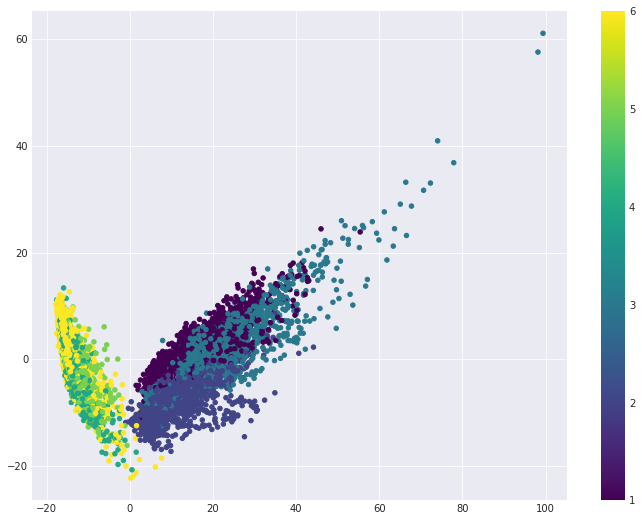

In [15]:
# Ваш код здесь
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, s=20, cmap='viridis');
plt.colorbar();

**Вопрос 3:**<br>
Если все получилось правильно, Вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?<br>

**Ответ:**
- 1 кластер: все 6 активностей
- 2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание) **[+]**
- 3 кластера: (ходьба), (подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 6 кластеров

------------------------------

Сделайте кластеризацию данных методом `KMeans`, обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

- **n_clusters** = n_classes (число уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

In [16]:
kms = KMeans(n_clusters=6, n_init=100, random_state=RANDOM_STATE).fit(X_pca)

In [17]:
cluster_labels = kms.labels_

Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

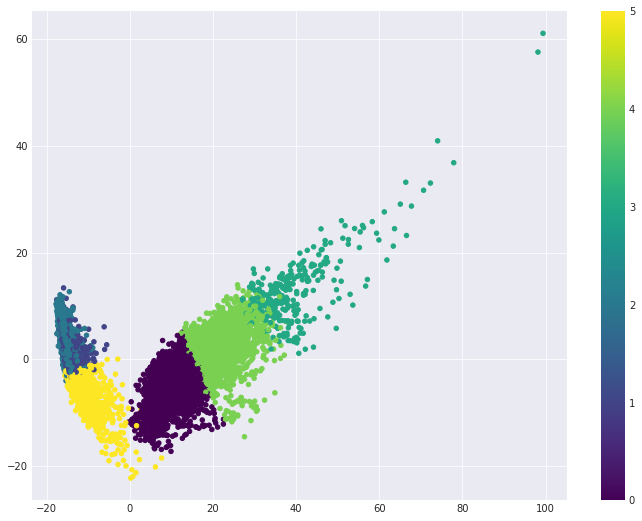

In [18]:
# Ваш код здесь
plt.scatter(X_pca[:,0], X_pca[:,1], c=cluster_labels, s=20,  cmap='viridis');
plt.colorbar();

Посмотрите на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм `KMeans` путает.

In [19]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,903,0,0,78,741,0,1722
подъем вверх по лестнице,1241,0,0,5,296,2,1544
спуск по лестнице,320,0,0,196,890,0,1406
сидение,1,1235,91,0,0,450,1777
стояние,0,1344,0,0,0,562,1906
лежание,5,52,1558,0,0,329,1944
все,2470,2631,1649,279,1927,1343,10299


In [20]:
tab['max_share'] = tab.iloc[:, 0:5].apply(lambda x: np.max(x), axis=1)/tab['все']

In [21]:
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все,max_share
ходьба,903,0,0,78,741,0,1722,0.524390
подъем вверх по лестнице,1241,0,0,5,296,2,1544,0.803756
спуск по лестнице,320,0,0,196,890,0,1406,0.633001
сидение,1,1235,91,0,0,450,1777,0.694992
стояние,0,1344,0,0,0,562,1906,0.705142
лежание,5,52,1558,0,0,329,1944,0.801440
все,2470,2631,1649,279,1927,1343,10299,0.255462


Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации. 

Пример: если для класса "спуск по лестнице", в котором 1406 объектов,  распределение кластеров такое:
 - кластер 1 – 900
 - кластер 3 – 500
 - кластер 6 – 6,
 
то такая доля будет 900 / 1406 $\approx$ 0.64.
 

**Вопрос 4:**<br>
Какой вид активности отделился от остальных лучше всего в терминах простой  метрики, описанной выше?<br>

**Ответ:**
- ходьба
- стояние
- спуск по лестнице
- нет верного ответа **[+]**

Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте метод локтя, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные используем те же, что раньше, меняем только `n_clusters`.

In [22]:
# Ваш код здесь
inertia = []
for k in tqdm_notebook(range(1, n_classes + 1)):
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE).fit(X_pca)
    inertia.append(np.sqrt(kmeans.inertia_))

A Jupyter Widget

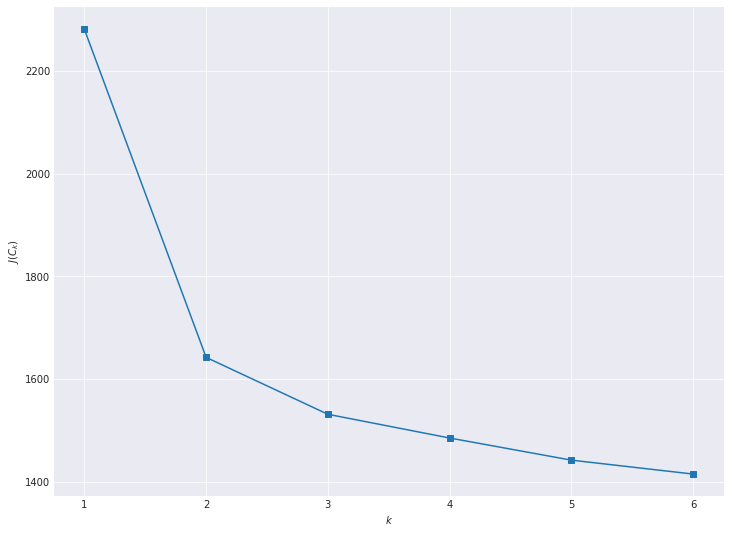

In [23]:
plt.plot(range(1, n_classes+1), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

**Вопрос 5:**<br>
Какое количество кластеров оптимально выбрать, согласно методу локтя?<br>

**Ответ:**
- 1
- 2**[+]**
- 3
- 4

------------------------

Попробуем еще один метод кластеризации, который описывался в статье – агломеративную кластеризацию.

In [24]:
ag = AgglomerativeClustering(n_clusters=n_classes, 
                             linkage='ward').fit(X_pca)

Посчитайте Adjusted Rand Index (`sklearn.metrics`) для получившегося разбиения на кластеры и для `KMeans` с параметрами из задания к 4 вопросу.

In [25]:
print("ARI for Agglomerative Clustering: {}".format(round(metrics.adjusted_rand_score(y, ag.labels_), 4))),
print("ARI for KMeans: {}".format(round(metrics.adjusted_rand_score(y, kms.labels_), 4)))

ARI for Agglomerative Clustering: 0.4936
ARI for KMeans: 0.4198


**Вопрос 6:**<br>
Отметьте все верные утверждения.<br>

**Варианты:**
- Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering **[+]**
- Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры
- В случае случайного разбиения на кластеры ARI будет близок к нулю **[+]**

-------------------------------

Можно заметить, что задача не очень хорошо решается именно как задача кластеризации, если выделять несколько кластеров (> 2). Давайте теперь решим задачу классификации, вспомнив, что данные у нас размечены.  

Для классификации используйте метод опорных векторов – класс `sklearn.svm.LinearSVC`. Мы в курсе отдельно не рассматривали этот алгоритм, но он очень известен, почитать про него можно, например, в материалах Евгения Соколова –  [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem11_linear.pdf). 

Настройте для `LinearSVC` гиперпараметр `C` с помощью `GridSearchCV`. 

- Обучите новый `StandardScaler` на обучающей выборке (со всеми исходными признаками), примените масштабирование к тестовой выборке
- В `GridSearchCV` укажите  cv=3.

In [158]:
# Ваш код здесь
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [159]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [160]:
%%time
best_svc = GridSearchCV(svc, svc_params, cv=3, n_jobs=-1, verbose=1).fit(X_train_scaled, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   15.7s finished


CPU times: user 7.52 s, sys: 151 ms, total: 7.67 s
Wall time: 22.4 s


In [161]:
best_svc.best_params_

{'C': 0.1}

**Вопрос 7**<br>
Какое значение гиперпараметра `C` было выбрано лучшим по итогам кросс-валидации?<br>

**Ответ:**
- 0.001
- 0.01
- 0.1 **[+]**
- 1
- 10

In [162]:
from collections import Counter
Counter(y_test)

Counter({1: 496, 2: 471, 3: 420, 4: 491, 5: 532, 6: 537})

In [163]:
y_predicted = best_svc.predict(X_test_scaled)

In [164]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице', 
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = tab.index
tab

,ходьба,подъем вверх по лестнице,спуск по лестнице,сидение,стояние,лежание,все
ходьба,494,2,0,0,0,0,496
подъем вверх по лестнице,12,459,0,0,0,0,471
спуск по лестнице,2,4,413,1,0,0,420
сидение,0,4,0,426,61,0,491
стояние,0,0,0,15,517,0,532
лежание,0,0,0,0,11,526,537
все,508,469,413,442,589,526,2947


In [165]:
prc = []
rcl = []

for i in range(tab.shape[1]):
    prc = np.append(prc, tab.iloc[i, i]/(np.sum(tab.iloc[i, :-1])))
    rcl = np.append(rcl, tab.iloc[i, i]/(tab.iloc[6,i]))

tab['recall'] = prc
tab['precision'] = rcl

In [166]:
tab

,ходьба,подъем вверх по лестнице,спуск по лестнице,сидение,стояние,лежание,все,recall,precision
ходьба,494,2,0,0,0,0,496,0.995968,0.972441
подъем вверх по лестнице,12,459,0,0,0,0,471,0.974522,0.978678
спуск по лестнице,2,4,413,1,0,0,420,0.983333,1.000000
сидение,0,4,0,426,61,0,491,0.867617,0.963801
стояние,0,0,0,15,517,0,532,0.971805,0.877759
лежание,0,0,0,0,11,526,537,0.979516,1.000000
все,508,469,413,442,589,526,2947,1.000000,1.000000


In [168]:
quality = 0
for i in range(tab.shape[0]-1):
    quality += tab.iloc[i,i]
quality

2835

**Вопрос 8:**<br>
Какой вид активности SVM определяет хуже всего в терминах точности? Полноты? <br>

**Ответ:**
- по точности – подъем вверх по лестнице, по полноте – лежание
- по точности – лежание, по полноте – сидение
- по точности – ходьба, по полноте – ходьба
- по точности – стояние, по полноте – сидение **[+]**

Наконец, проделайте то же самое, что в 7 вопросе, только добавив PCA.

- Используйте выборки `X_train_scaled` и `X_test_scaled`
- Обучите тот же PCA, что раньше, на отмасшабированной обучающей выборке, примените преобразование к тестовой
- Настройте гиперпараметр `C` на кросс-валидации по обучающей выборке с PCA-преобразованием. Вы заметите, насколько это проходит быстрее, чем раньше.

**Вопрос 9:**<br>
Какова разность между лучшим качеством (долей верных ответов) на кросс-валидации в случае всех 561 исходных признаков и во втором случае, когда применялся метод главных компонент? Округлите до целых процентов.<br>

**Варианты:**
- Качество одинаковое
- 2%
- 4% **[+]**
- 10%
- 20%


In [169]:
pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [170]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [171]:
%%time
best_svc = GridSearchCV(svc, svc_params, cv=3, n_jobs=-1, verbose=1).fit(X_train_pca, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    3.1s finished


CPU times: user 1.65 s, sys: 88.1 ms, total: 1.74 s
Wall time: 4.72 s


In [172]:
best_svc.best_params_

{'C': 0.1}

In [173]:
y_predicted = best_svc.predict(X_test_pca)

In [174]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице', 
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = tab.index

prc = []
rcl = []

for i in range(tab.shape[1]):
    prc = np.append(prc, tab.iloc[i, i]/(np.sum(tab.iloc[i, :-1])))
    rcl = np.append(rcl, tab.iloc[i, i]/(tab.iloc[6,i]))

tab['recall'] = prc
tab['precision'] = rcl

tab

,ходьба,подъем вверх по лестнице,спуск по лестнице,сидение,стояние,лежание,все,recall,precision
ходьба,474,16,5,0,0,1,496,0.955645,0.892655
подъем вверх по лестнице,49,402,20,0,0,0,471,0.853503,0.909502
спуск по лестнице,5,22,391,0,1,1,420,0.930952,0.939904
сидение,0,2,0,422,66,1,491,0.859470,0.909483
стояние,3,0,0,40,488,1,532,0.917293,0.879279
лежание,0,0,0,2,0,535,537,0.996276,0.992579
все,531,442,416,464,555,539,2947,1.000000,1.000000


In [175]:
quality = 0
for i in range(tab.shape[0]-1):
    quality += tab.iloc[i,i]
quality

2712

**Вопрос 10:**<br>
Выберите все верные утверждения:

**Варианты:**
- Метод главных компонент в данном случае позволил уменьшить время обучения модели, при этом качество (доля верных ответов на кросс-валидации) очень пострадало, более чем на 10% **[-]**
- PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность **[+]**
- PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком **[+]**